<a href="https://colab.research.google.com/github/B-j-jose/Assignments-semseter-two/blob/master/Exercise_NLP_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis On Google Play Reviews 

### Introduction

#### In this notebook, I will leverage the power of the Bert pretrained model and Bert Tokenizer from Hugging Face to perform sentiment analysis on customer reviews. The dataset used for this task is a collection of customer reviews extracted from Google Play app reviews. The dataset was sourced from the Internet, providing a diverse range of feedback and opinions to analyze. 

#### By harnessing the capabilities of Bert and the rich information encoded in the reviews, I aim to uncover valuable insights and sentiments expressed by the customers.

## Importing Libraries

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from collections.abc import Mapping
import json


from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

####  Configurations for creating a customised dataset and plots

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration

#### Downloading google play app reviews dataset.

In [ ]:
!gdown 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 38.3MB/s]


##### Reading the datasets

In [ ]:
Reviews = pd.read_csv("reviews.csv")
Reviews

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo
...,...,...,...,...,...,...,...,...,...,...,...
15741,Tammy Kay,https://lh3.googleusercontent.com/a-/AOh14GhYP...,I believe that this is by far the best app wit...,5,0,NaN,2018-02-17 06:09:03,NaN,NaN,newest,com.appxy.planner
15742,Ysm Johan,https://lh3.googleusercontent.com/a-/AOh14Ggmd...,It sometimes crashes a lot!!,5,0,4.3.7,2018-02-15 10:45:22,NaN,NaN,newest,com.appxy.planner
15743,casey dearden,https://lh3.googleusercontent.com/a-/AOh14Gg2U...,Works well for what I need,5,0,4.3.7,2018-02-09 18:40:37,NaN,NaN,newest,com.appxy.planner
15744,Jerry G Tamate,https://lh3.googleusercontent.com/a-/AOh14GiTP...,Love it.,5,0,NaN,2018-02-06 12:36:17,NaN,NaN,newest,com.appxy.planner


#### Examining the shape of the Dataset 

In [ ]:
Reviews.shape

(15746, 11)

#### Examining the Dataset

In [ ]:
Reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


####  Examining the review scores using a bar plot

In [ ]:
Scores = Reviews['score'].value_counts()
Scores

3    5042
5    2900
4    2776
1    2566
2    2462
Name: score, dtype: int64

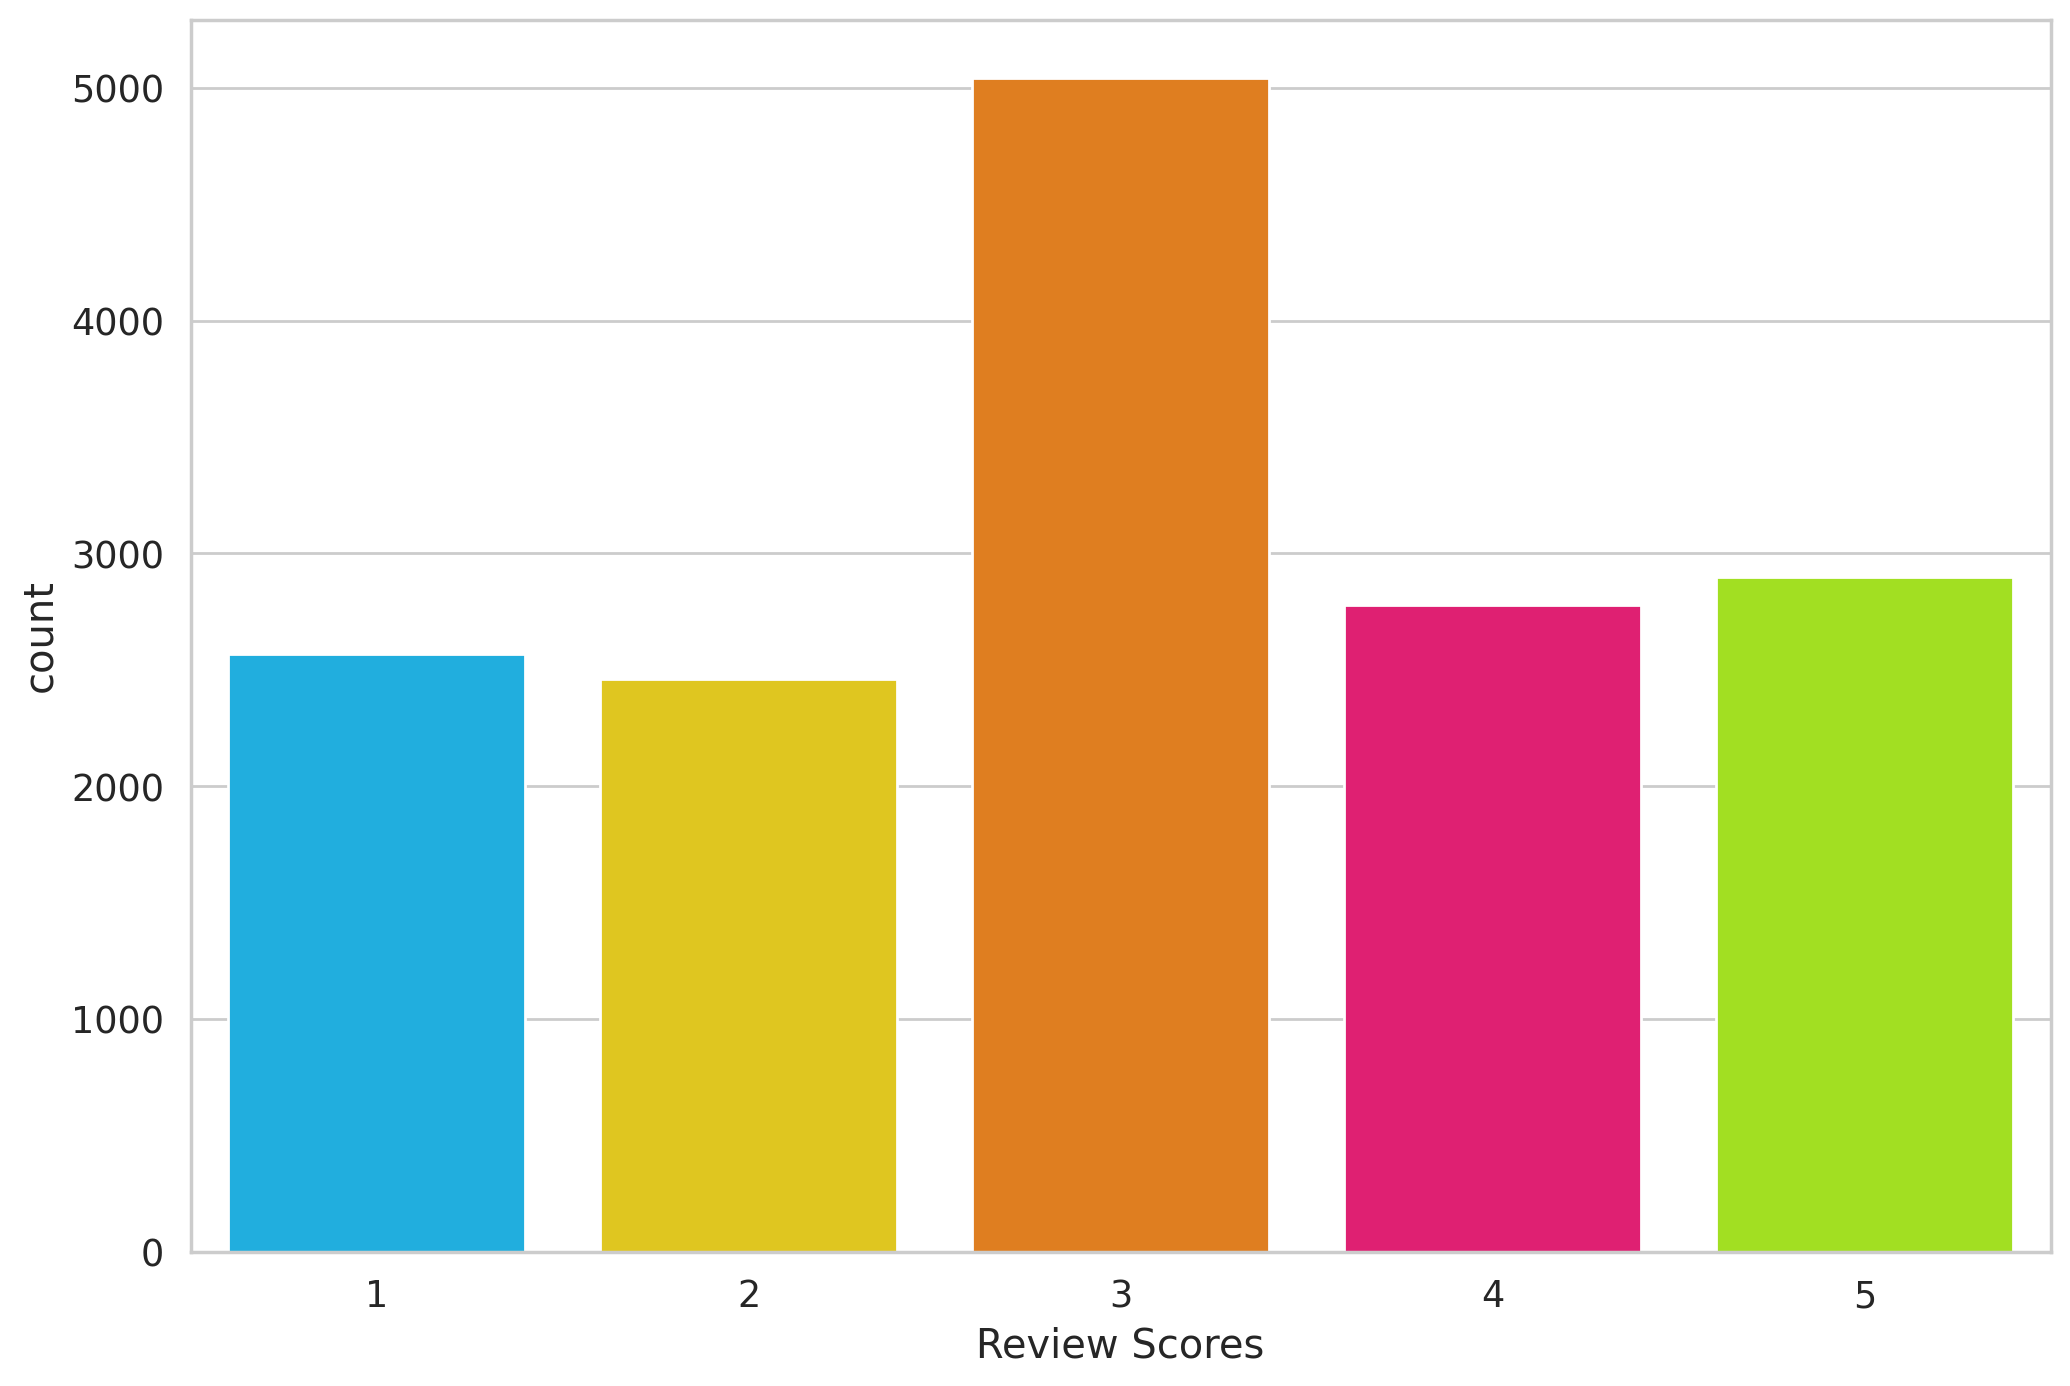

In [ ]:
sns.countplot(x='score', data = Reviews)
plt.xlabel('Review Scores');

The scores are imbalanced which might lead to classifiers making biased learning model. I will convert the scores into negative , neutral and positive

### Converting the scores to have data balance 

##### Defining a function to group the scores and create a column called sentiment

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

Reviews['sentiment'] = Reviews.score.apply(to_sentiment)

####  Defining sentiment names

In [ ]:
class_names = ['Negative','Neutral','Positive']

##### Plotting new bar with the sentiments

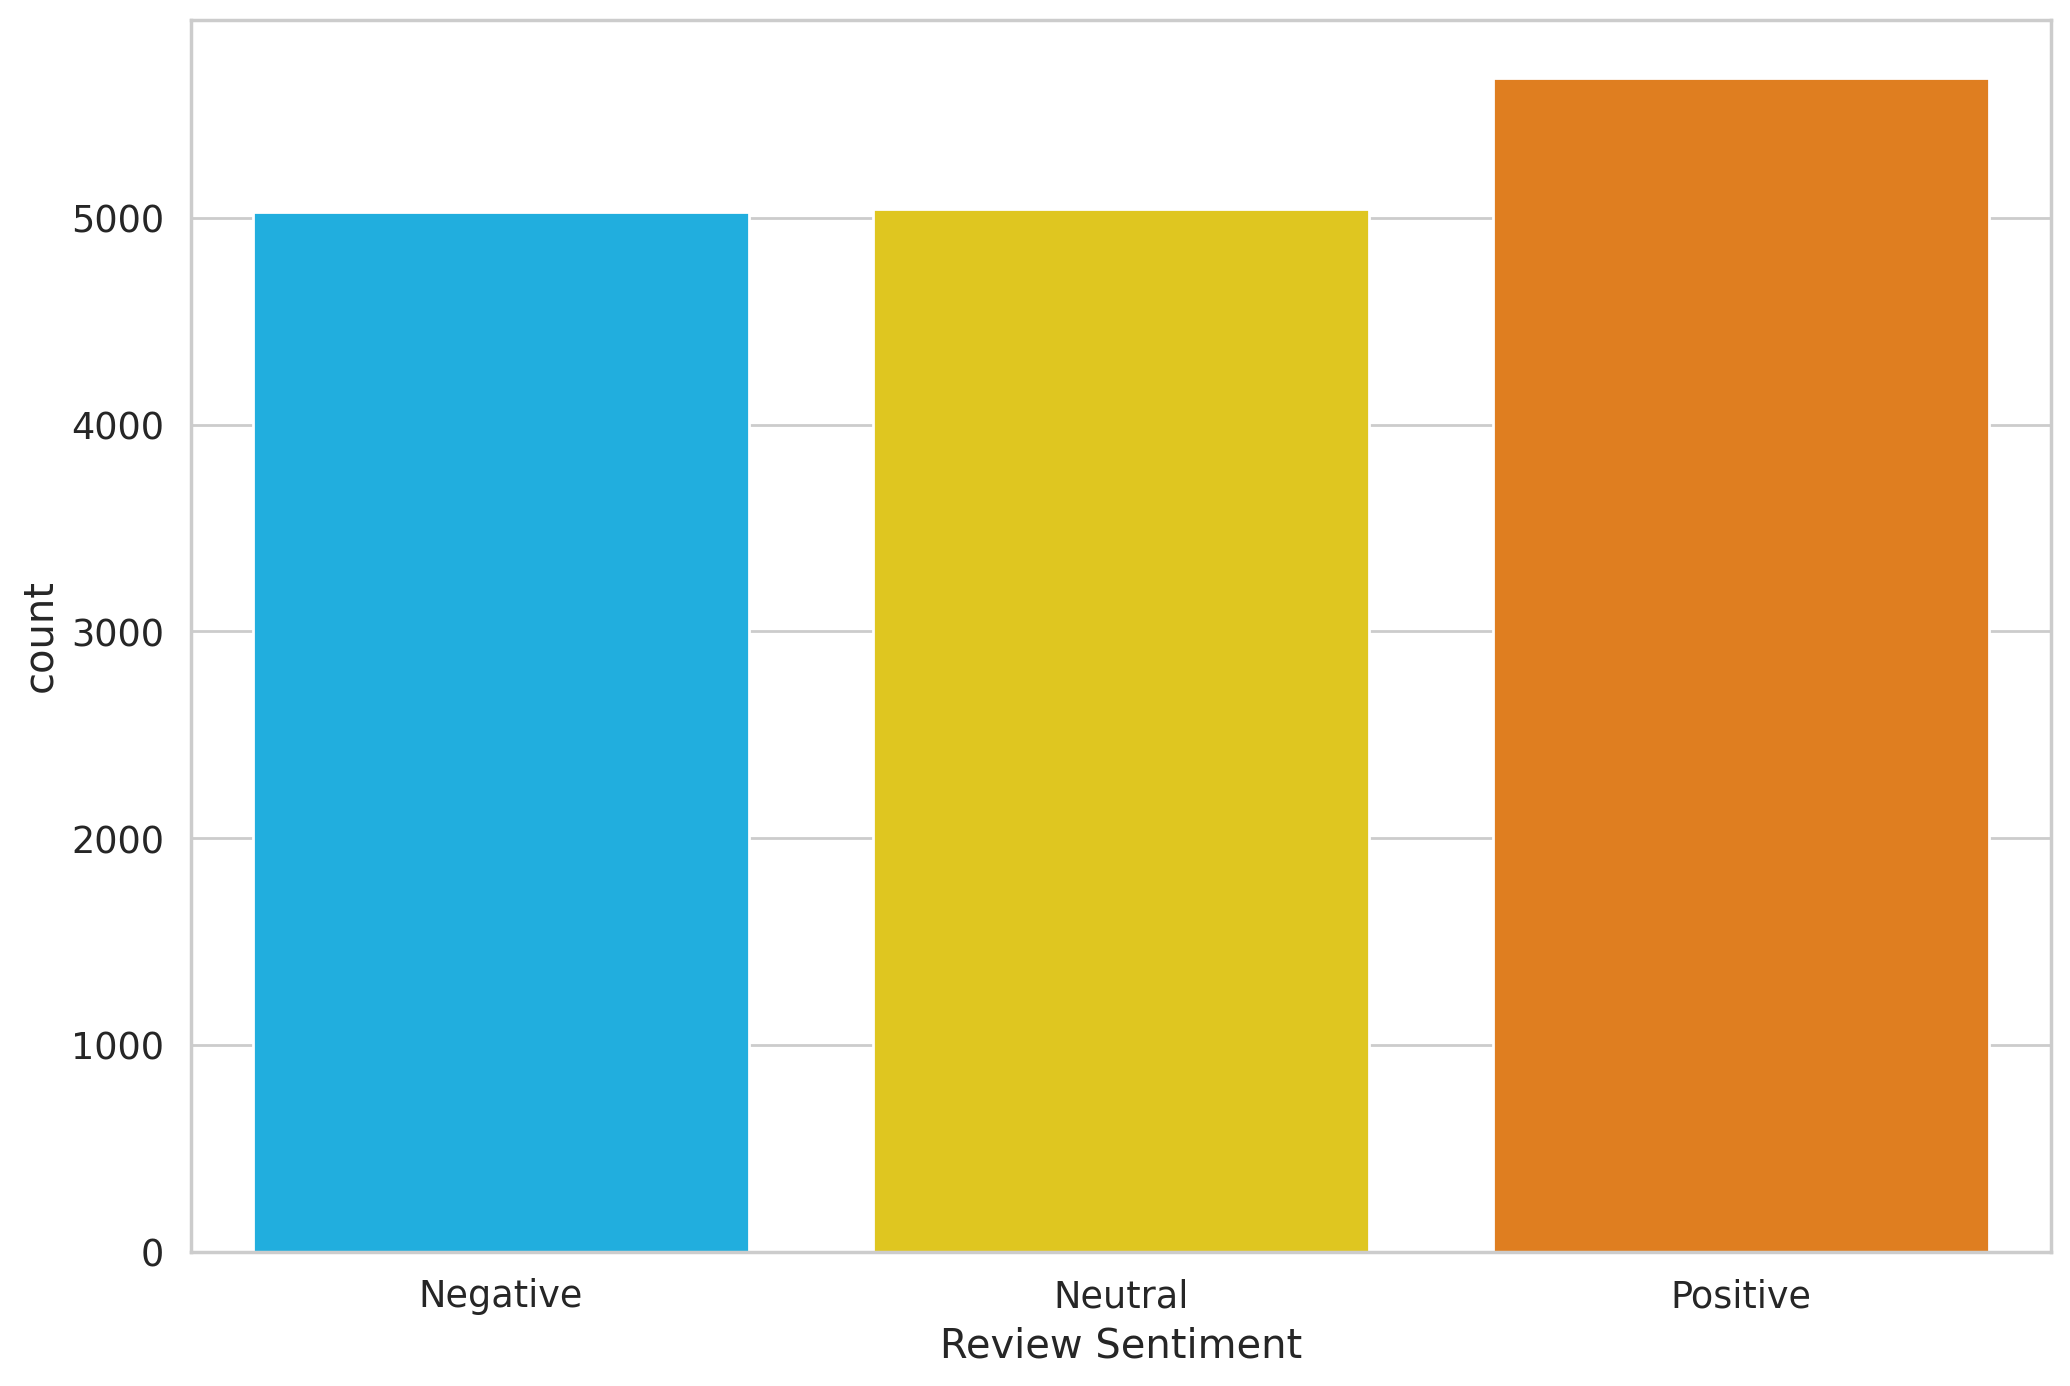

In [ ]:
ax = sns.countplot(x='sentiment', data = Reviews)
plt.xlabel('Review Sentiment')
ax.set_xticklabels(class_names);

##### We can see some balance between the sentiments (scores). This implies that the data quality is fair enough

## Data Preprocessing

#### Downloading Bert Tokenizer

##### Tokenization is a common task in text data processing. It involves splitting a phrase, sentence, paragraph, or document into smaller units called tokens, such as individual words or terms. This is important because analyzing the words in the text helps interpret its meaning. The ultimate goal of tokenization is to create a vocabulary of these tokens.

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

### Checking how the tokenizer performs

In [ ]:
sample_txt = 'I have not eaten since morning! I am stuck with the exercise.'

##### Exploring the tokenization process

In [ ]:
# Getting tokens from the tokenizer
tokens = tokenizer.tokenize(sample_txt) 

# Converting tokens to corresponding IDS
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: I have not eaten since morning! I am stuck with the exercise.
   Tokens: ['I', 'have', 'not', 'eaten', 'since', 'morning', '!', 'I', 'am', 'stuck', 'with', 'the', 'exercise', '.']
Token IDs: [146, 1138, 1136, 8527, 1290, 2106, 106, 146, 1821, 5342, 1114, 1103, 6730, 119]


#### Exploring Special tokens in the Bert training

In [ ]:
# Separation Token
tokenizer.sep_token,tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
# Classification Token
tokenizer.cls_token,tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
# Padding Token
tokenizer.pad_token,tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
# Unknown Token
tokenizer.unk_token,tokenizer.unk_token_id

('[UNK]', 100)

 ### Defining the Encode_plus() method

##### This method will call on all the steps required for the tokenization and data preprocessing of the text 

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,#fixed length of our text
  truncation=True,
  add_special_tokens=True, 
  return_token_type_ids=False,
  padding=True,
  return_attention_mask=True,
  return_tensors='pt',  
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

##### Examining the input IDS

In [ ]:
encoding['input_ids']

tensor([[ 101,  146, 1138, 1136, 8527, 1290, 2106,  106,  146, 1821, 5342, 1114,
         1103, 6730,  119,  102]])

##### We can see that two tokens have been added to the sequence by the tokenizer the 101 and 102 

#### Examining the attention_mask

In [ ]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

#### Inversing the tokenization to check for the special tokens

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'I',
 'have',
 'not',
 'eaten',
 'since',
 'morning',
 '!',
 'I',
 'am',
 'stuck',
 'with',
 'the',
 'exercise',
 '.',
 '[SEP]']

#### Choosing the sequence length

###### A function to store the token length for each review

In [ ]:
token_lens = []

for txt in Reviews.content:
  tokens = tokenizer.encode(txt, max_length=512,truncation=True)
  token_lens.append(len(tokens))   

###### PLoting the distribution

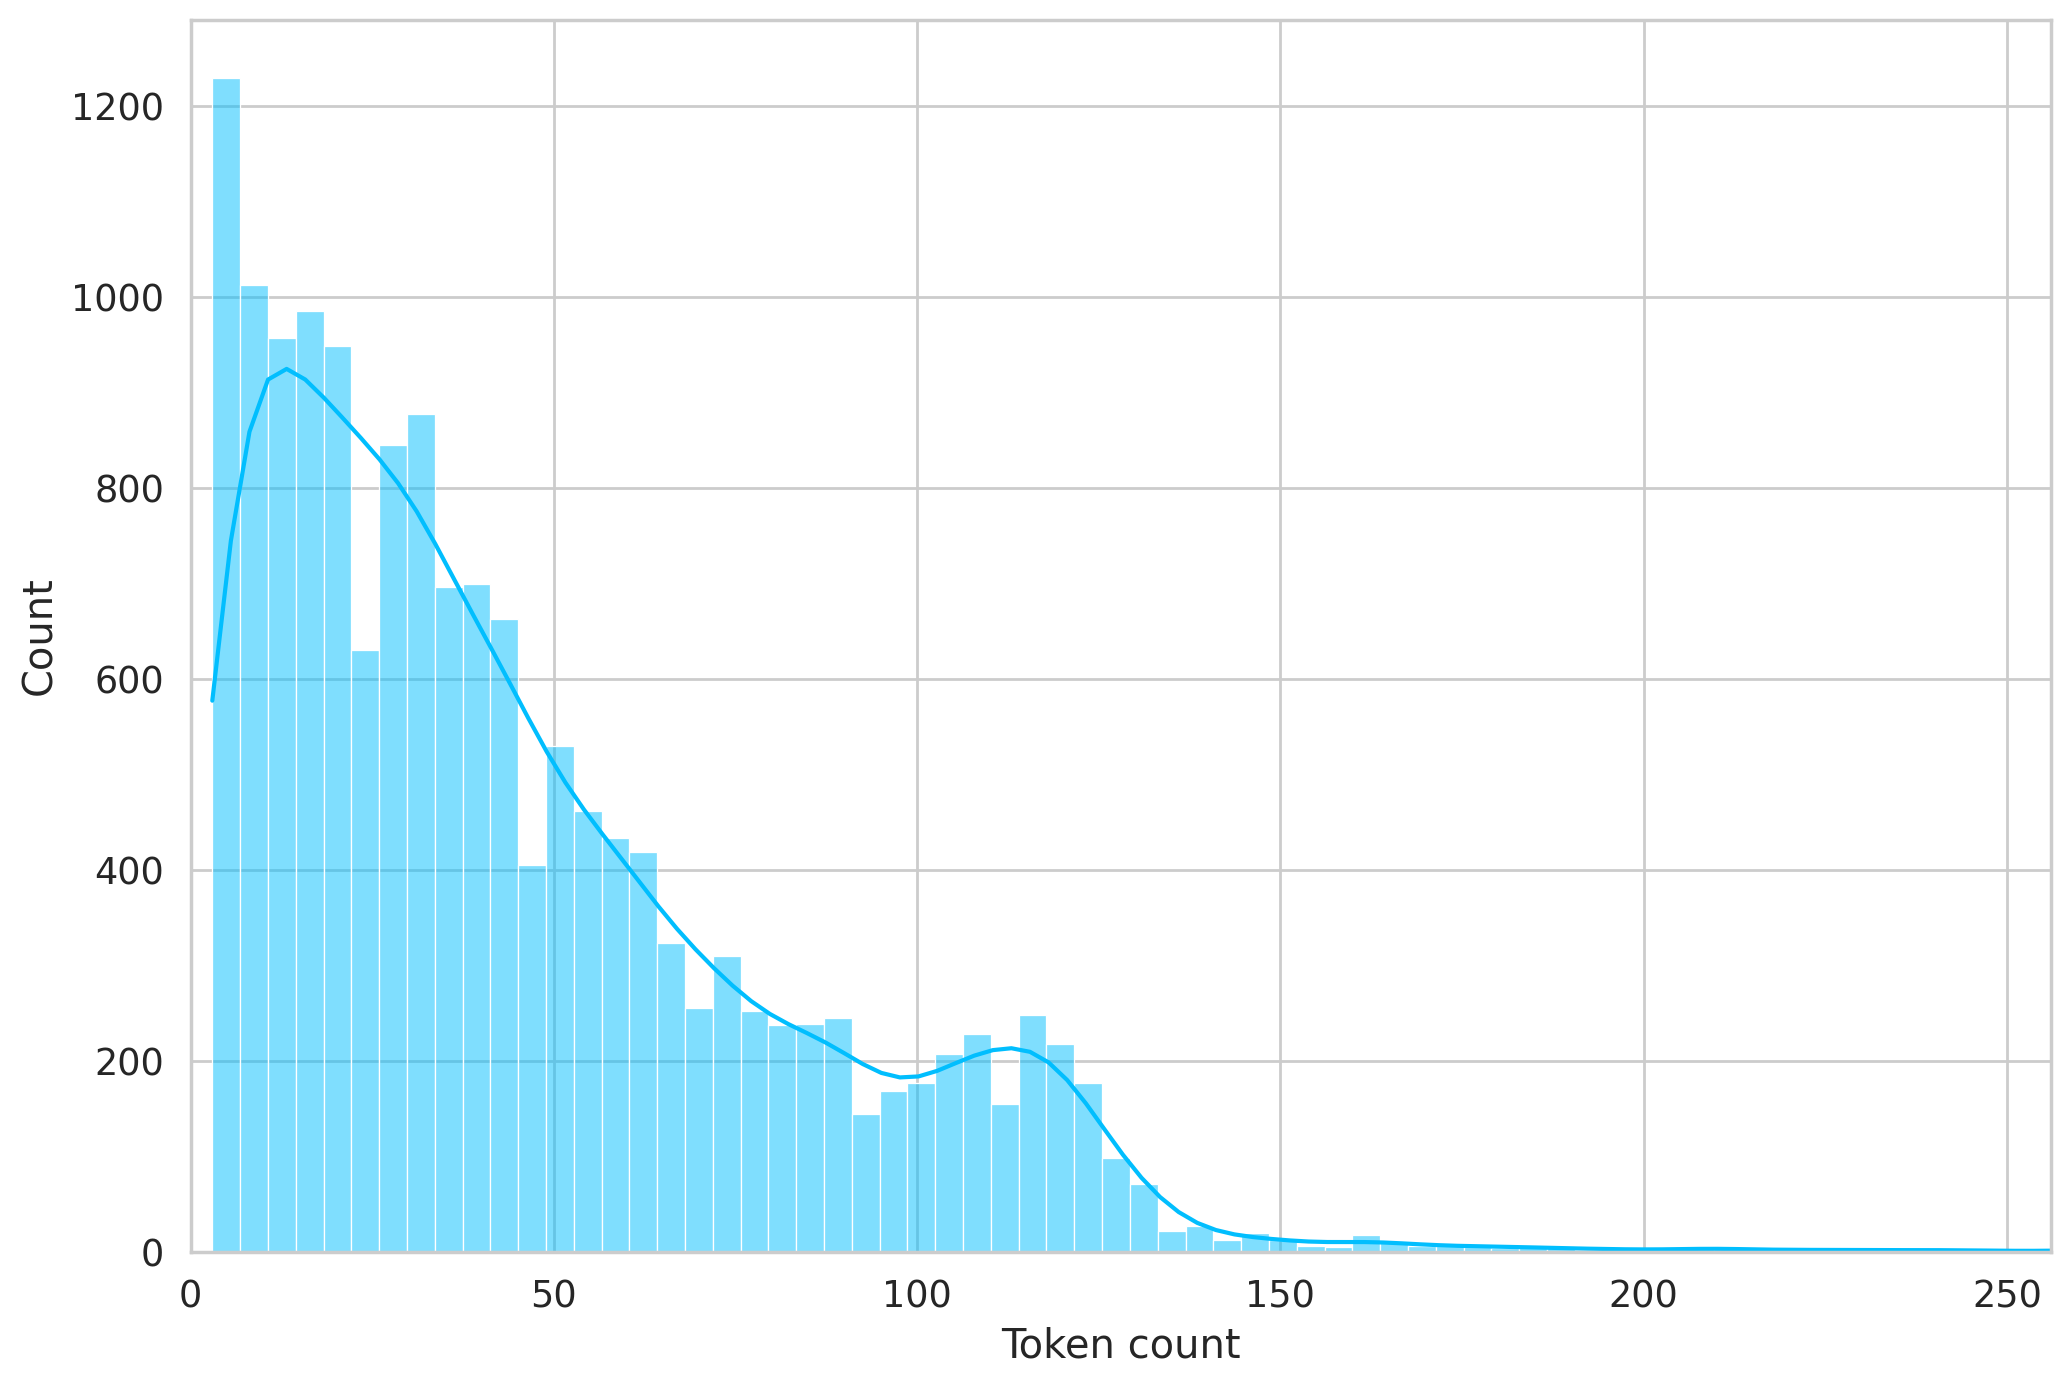

In [ ]:
sns.histplot(token_lens, kde=True)
plt.xlim([0, 256]);
plt.xlabel('Token count');

##### From the Plot, the observation is that most of the reviews are below 128. Most reviews have 128 tokens

### Creating a customised Dataset

In [ ]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews 
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    
    encoding = self.tokenizer.encode_plus(
      review,
      max_length=self.max_len,
      truncation=True,
      add_special_tokens=True, 
      return_token_type_ids=False,
      padding=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
MAX_LEN = 128
BATCH_SIZE = 8
EPOCHS = 20

In [ ]:
Reviews_train, Reviews_test = train_test_split(Reviews, test_size=0.2, random_state=RANDOM_SEED)
Reviews_val, Reviews_test = train_test_split(Reviews_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
Reviews_train.shape, Reviews_val.shape, Reviews_test.shape

((12596, 12), (1575, 12), (1575, 12))

In [ ]:
def collate_tensor_fn(batch):
    if isinstance(batch[0], torch.Tensor):
        filtered_batch = [tensor for tensor in batch if tensor.numel() > 0]
        if len(filtered_batch) == 0:
            return None
        if len(filtered_batch) == 1:
            return filtered_batch[0]
        if filtered_batch[0].dim() == 0:
            return torch.stack(filtered_batch, dim=0)
        max_size = max([tensor.size(0) for tensor in filtered_batch])
        if max_size == 0:
            return None
        padded_batch = []
        for tensor in filtered_batch:
            pad_size = max_size - tensor.size(0)
            padded_tensor = torch.nn.functional.pad(tensor, (0, pad_size), value=0)
            padded_batch.append(padded_tensor)
        if len(padded_batch) == 0:
            return None
        return torch.stack(padded_batch, dim=0)
    elif isinstance(batch[0], Mapping):
        return {key: collate_tensor_fn([d[key] for d in batch]) for key in batch[0]}
    else:
        return batch


In [ ]:
def create_data_loader(Reviews, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=Reviews.content.to_numpy(),
    targets=Reviews.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    collate_fn=collate_tensor_fn
  )

In [ ]:
train_data_loader = create_data_loader(Reviews_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(Reviews_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(Reviews_test, tokenizer, MAX_LEN, BATCH_SIZE) 

## Modelling 

### Downloading the  BERT pretrained model from Hugging Face

In [ ]:
bert_model = BertModel.from_pretrained('bert-base-cased') 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
EPOCHS = 20
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = torch.tensor(d["input_ids"]).clone().detach().to(device)
        attention_mask = torch.tensor(d["attention_mask"]).clone().detach().to(device)
        targets = torch.tensor(d["targets"]).clone().detach().to(device)
        
        # Add the following line to convert string labels to long tensors
        targets = targets.squeeze().long()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = torch.tensor(d["input_ids"]).clone().detach().to(device)
      attention_mask = torch.tensor(d["attention_mask"]).clone().detach().to(device)
      targets = torch.tensor(d["targets"]).clone().detach().to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(Reviews_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(Reviews_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


<ipython-input-43-3f8e73dff883>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(d["input_ids"]).clone().detach().to(device)
<ipython-input-43-3f8e73dff883>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(d["attention_mask"]).clone().detach().to(device)
<ipython-input-43-3f8e73dff883>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(d["targets"]).clone().detach().to(device)


Train loss 0.8594300774070952 accuracy 0.6000317561130518


<ipython-input-44-8bb06e877f51>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(d["input_ids"]).clone().detach().to(device)
<ipython-input-44-8bb06e877f51>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(d["attention_mask"]).clone().detach().to(device)
<ipython-input-44-8bb06e877f51>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(d["targets"]).clone().detach().to(device)


Val   loss 0.6996706160645799 accuracy 0.6888888888888889

Epoch 2/20
----------
Train loss 0.6235050309638656 accuracy 0.7528580501746587
Val   loss 0.7619113811495037 accuracy 0.7352380952380952

Epoch 3/20
----------
Train loss 0.4660501922495545 accuracy 0.8484439504604636
Val   loss 0.92511251110697 accuracy 0.766984126984127

Epoch 4/20
----------
Train loss 0.39242738798482435 accuracy 0.8965544617338838
Val   loss 0.9586467763791948 accuracy 0.8044444444444444

Epoch 5/20
----------
Train loss 0.32298332596922086 accuracy 0.9193394728485234
Val   loss 0.8959724915008236 accuracy 0.820952380952381

Epoch 6/20
----------
Train loss 0.25763063872188685 accuracy 0.9404572880279454
Val   loss 1.0035957602115093 accuracy 0.8152380952380952

Epoch 7/20
----------
Train loss 0.20769698129911418 accuracy 0.9544299777707209
Val   loss 0.953862531851093 accuracy 0.8323809523809523

Epoch 8/20
----------
Train loss 0.1653466463502541 accuracy 0.963639250555732
Val   loss 0.9368245905054837

In [ ]:
# Recursive function to convert tensors to CPU and lists
def to_cpu_and_list(obj):
    if isinstance(obj, torch.Tensor):
        obj = obj.detach().cpu().numpy()
    if isinstance(obj, np.ndarray):
        obj = obj.tolist()
    if isinstance(obj, dict):
        return {k: to_cpu_and_list(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [to_cpu_and_list(v) for v in obj]
    return obj

# Convert tensors to CPU and lists
history_cpu = to_cpu_and_list(history)

# Save history as a JSON file
with open('training_history.json', 'w') as file:
    json.dump(history_cpu, file)

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/mydrive')


Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


In [ ]:
# Define the path to save the training history on Google Drive
history_path = '/content/drive/MyDrive/Open Programme/training_history.json'

# Save history as a JSON file on Google Drive
with open(history_path, 'w') as file:
    json.dump(history_cpu, file)

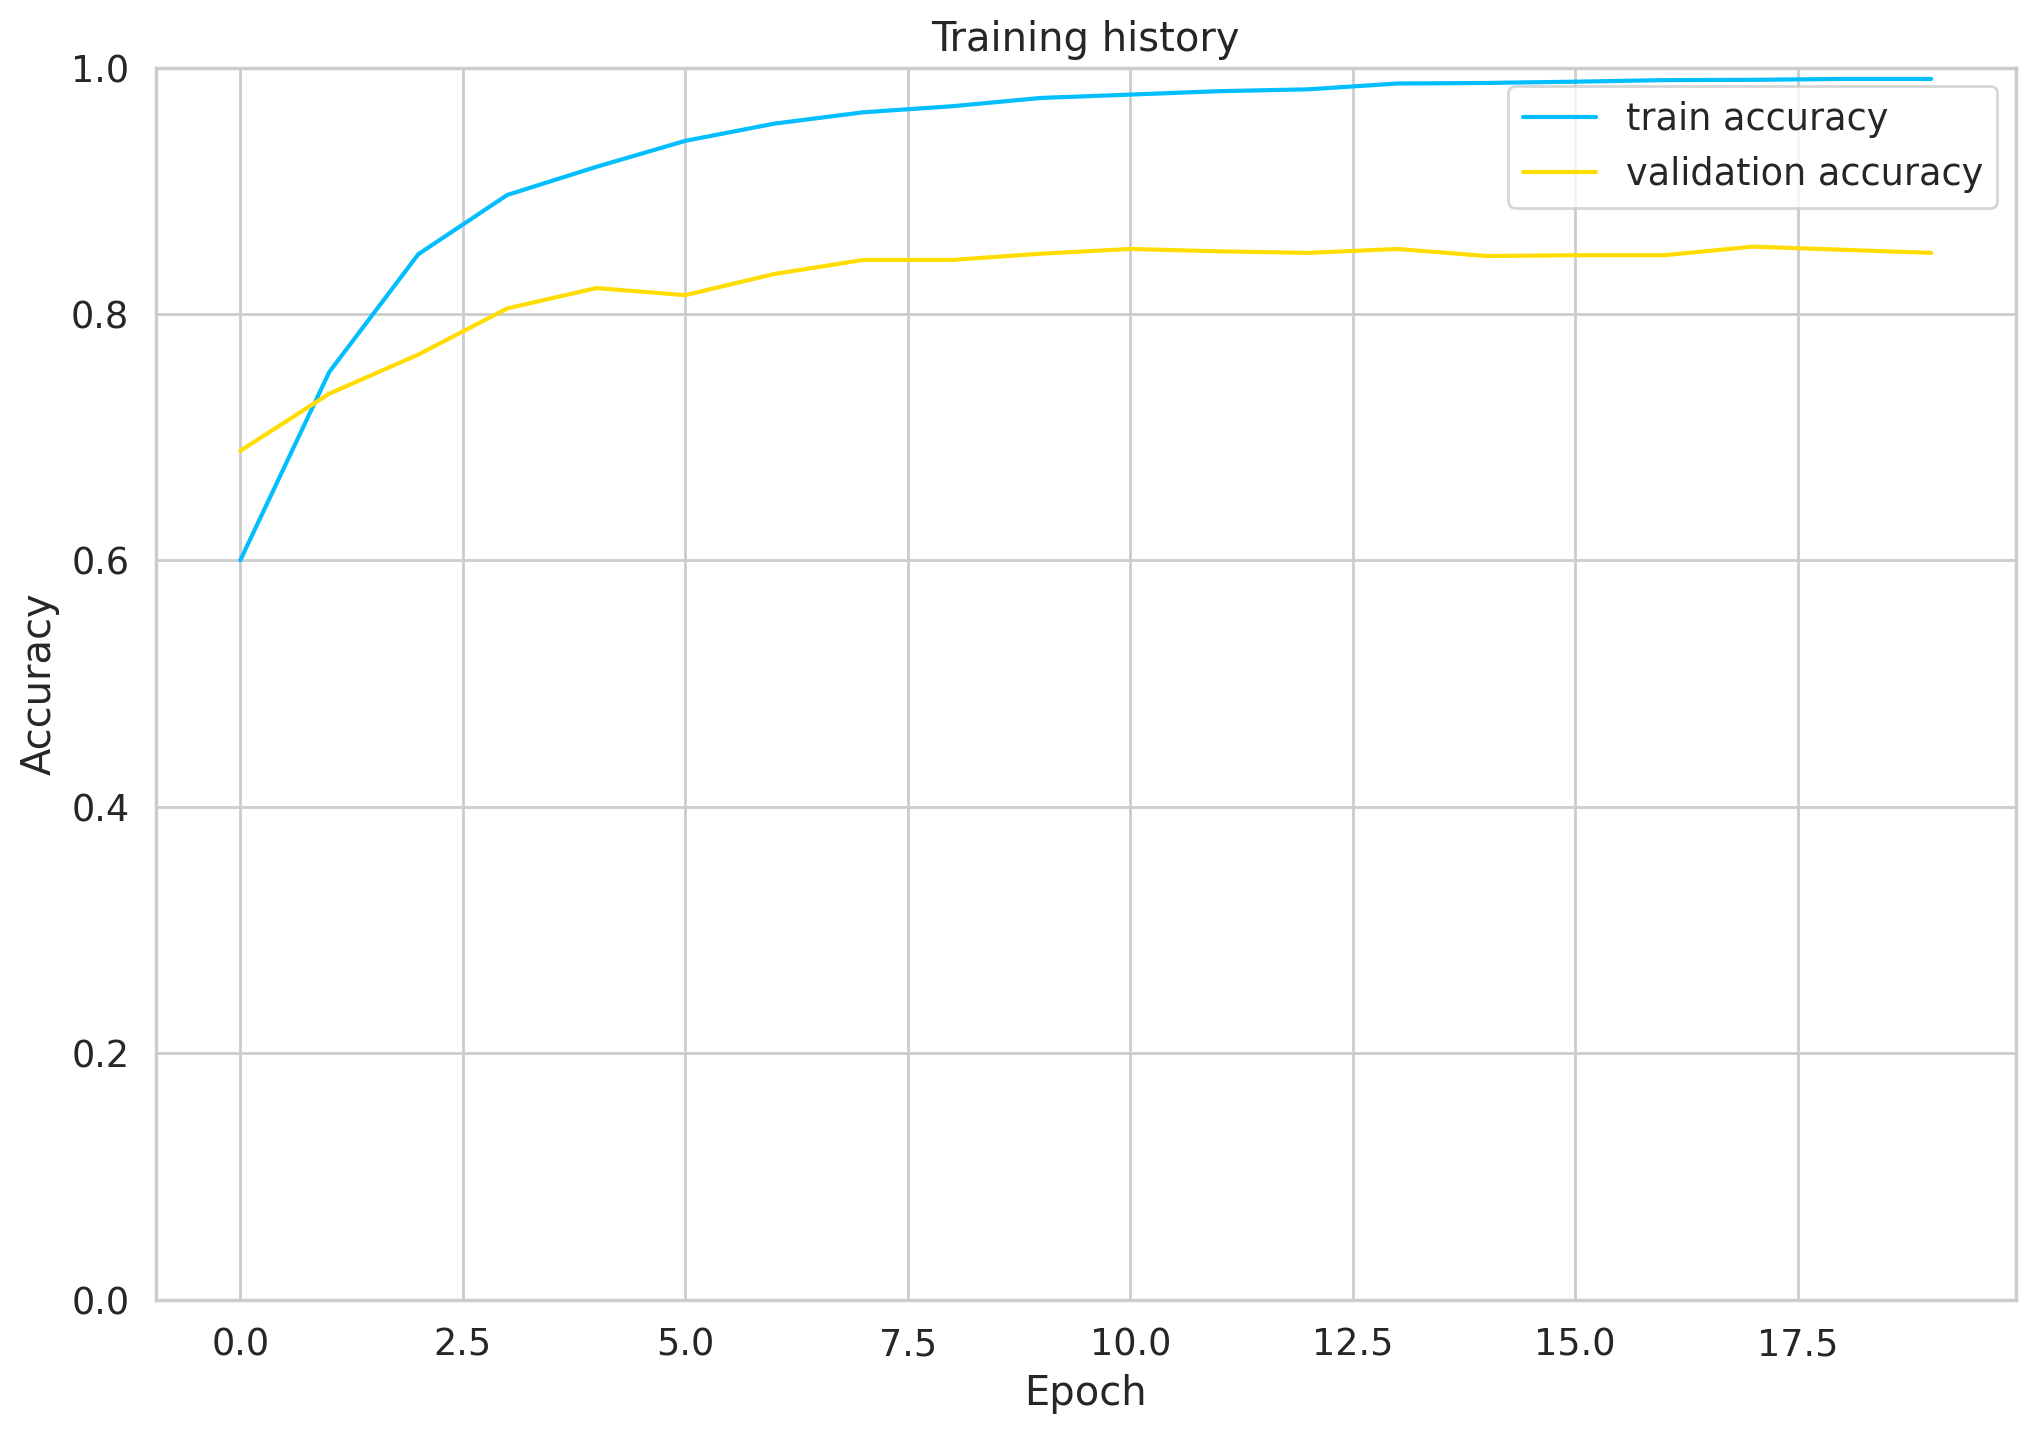

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_cpu['train_acc'], label='train accuracy')
plt.plot(history_cpu['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

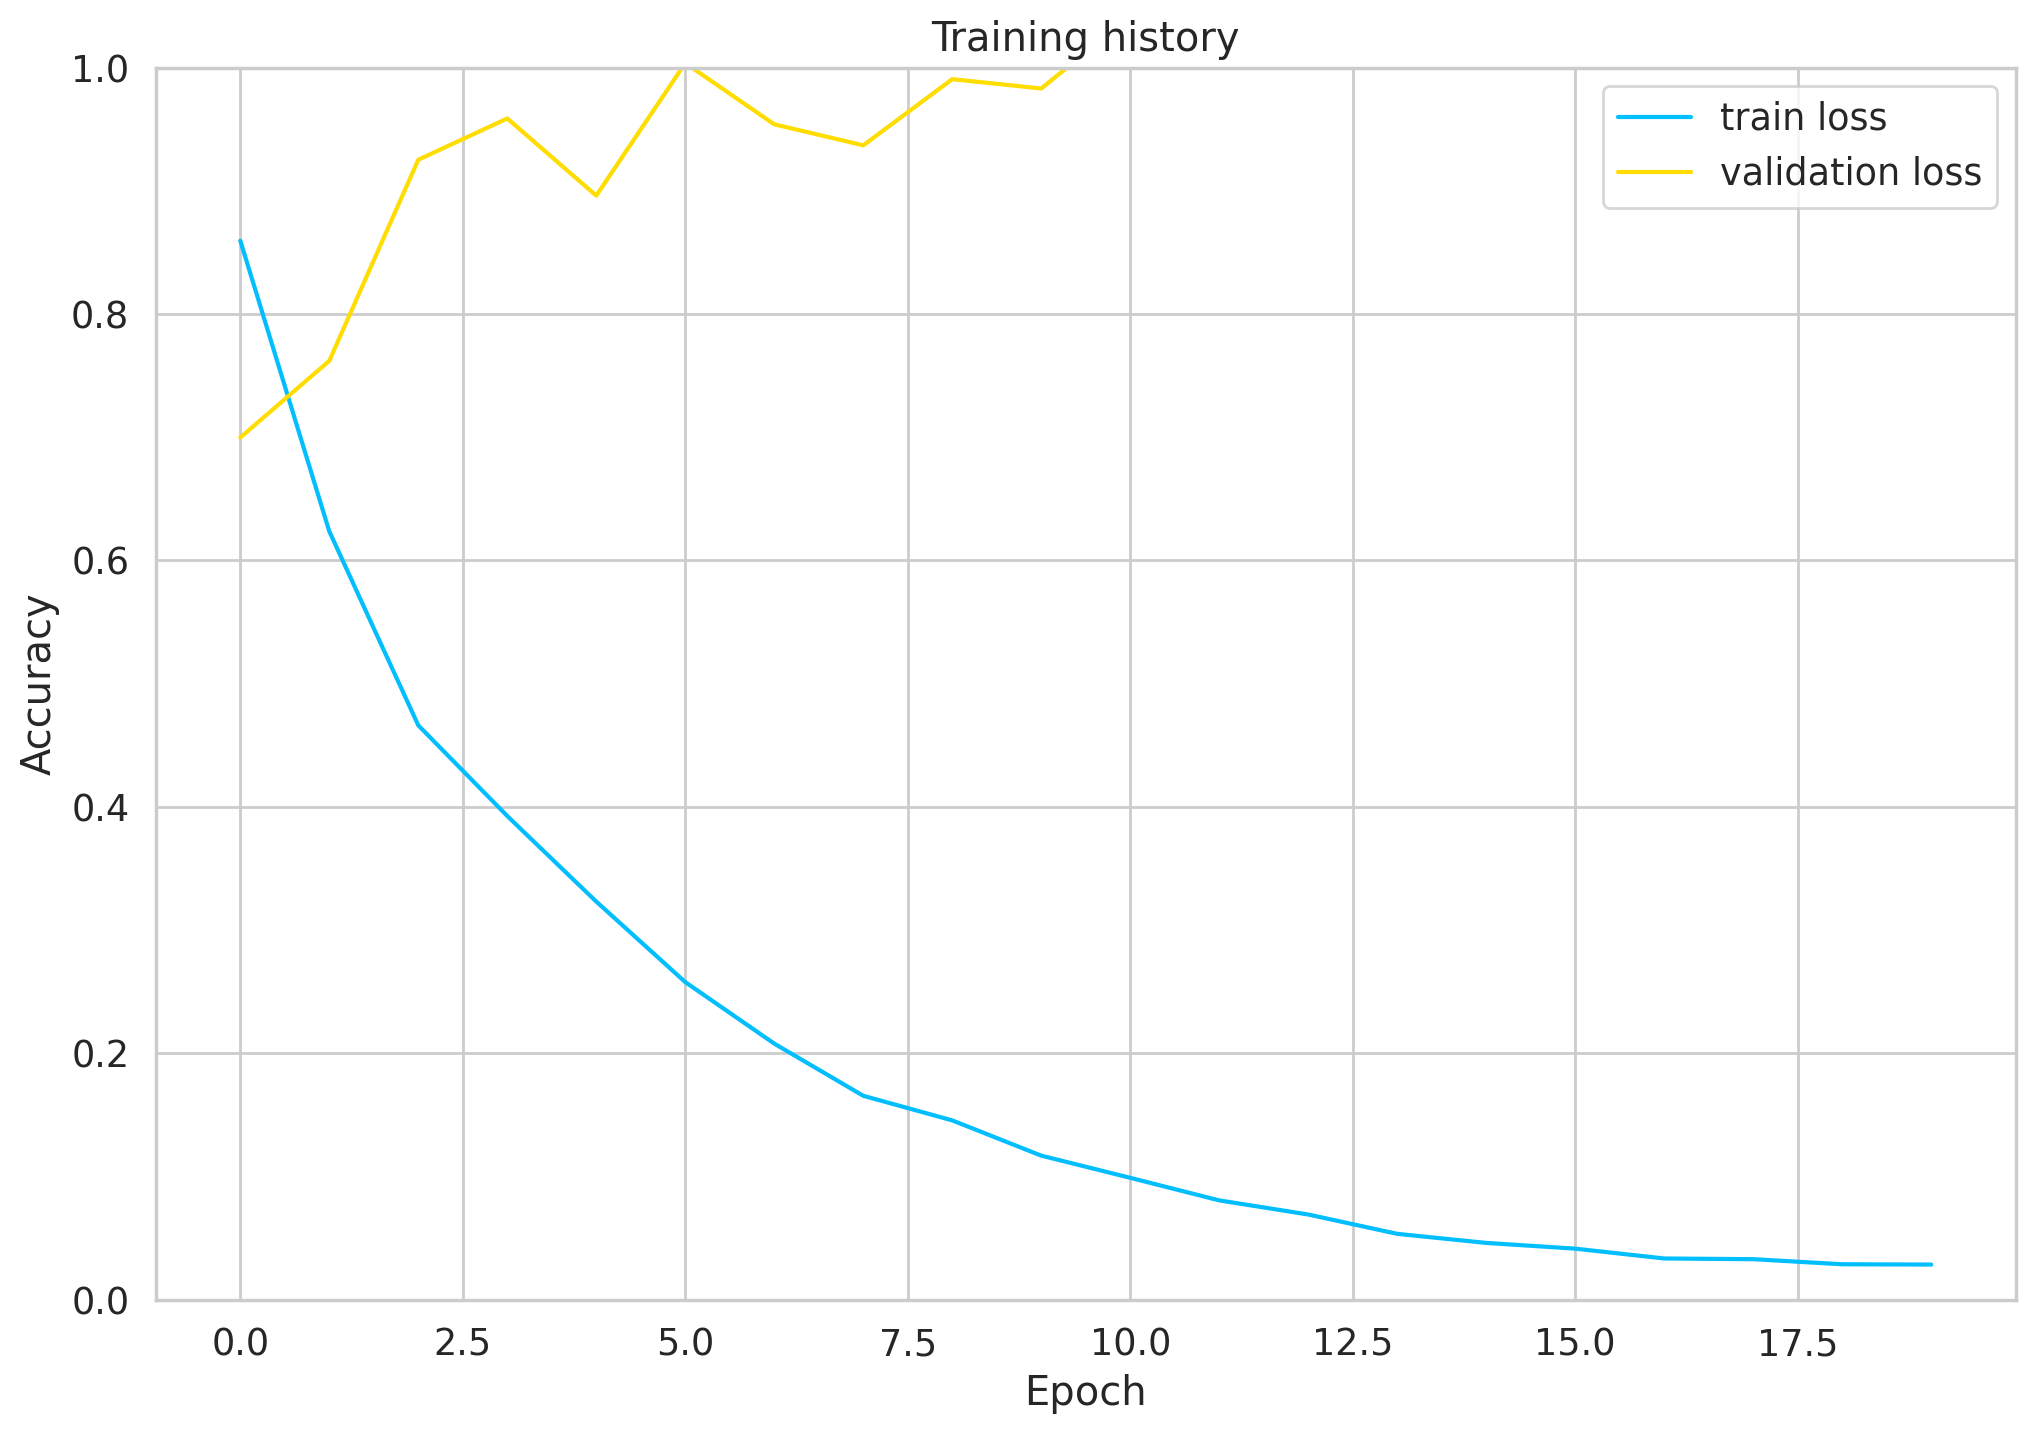

In [ ]:
plt.plot(history_cpu['train_loss'], label='train loss')
plt.plot(history_cpu['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Evaluation of the model

#### Checking the accuracy on the test set data

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(Reviews_test)
)
test_acc.item()

<ipython-input-44-8bb06e877f51>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(d["input_ids"]).clone().detach().to(device)
<ipython-input-44-8bb06e877f51>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(d["attention_mask"]).clone().detach().to(device)
<ipython-input-44-8bb06e877f51>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(d["targets"]).clone().detach().to(device)


0.8533333333333333

###### The model evaluation accuracy is 85% which is good accuracy score 

### Making Predictions using our model and the test reviews 

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = torch.tensor(d["input_ids"]).clone().detach().to(device)
      attention_mask = torch.tensor(d["attention_mask"]).clone().detach().to(device)
      targets = torch.tensor(d["targets"]).clone().detach().to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

<ipython-input-91-ab8a80d8a401>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(d["input_ids"]).clone().detach().to(device)
<ipython-input-91-ab8a80d8a401>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(d["attention_mask"]).clone().detach().to(device)
<ipython-input-91-ab8a80d8a401>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(d["targets"]).clone().detach().to(device)


### Checking the Classification report to see how the model performas on the three Reviews categories

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.90      0.84      0.87       519
     Neutral       0.77      0.83      0.80       466
    Positive       0.89      0.88      0.89       590

    accuracy                           0.85      1575
   macro avg       0.85      0.85      0.85      1575
weighted avg       0.86      0.85      0.85      1575



##### The model seems to perform well on the nuetral reviews compared of the negative and positive reviews. 

### Plotting the Confusion Matrix

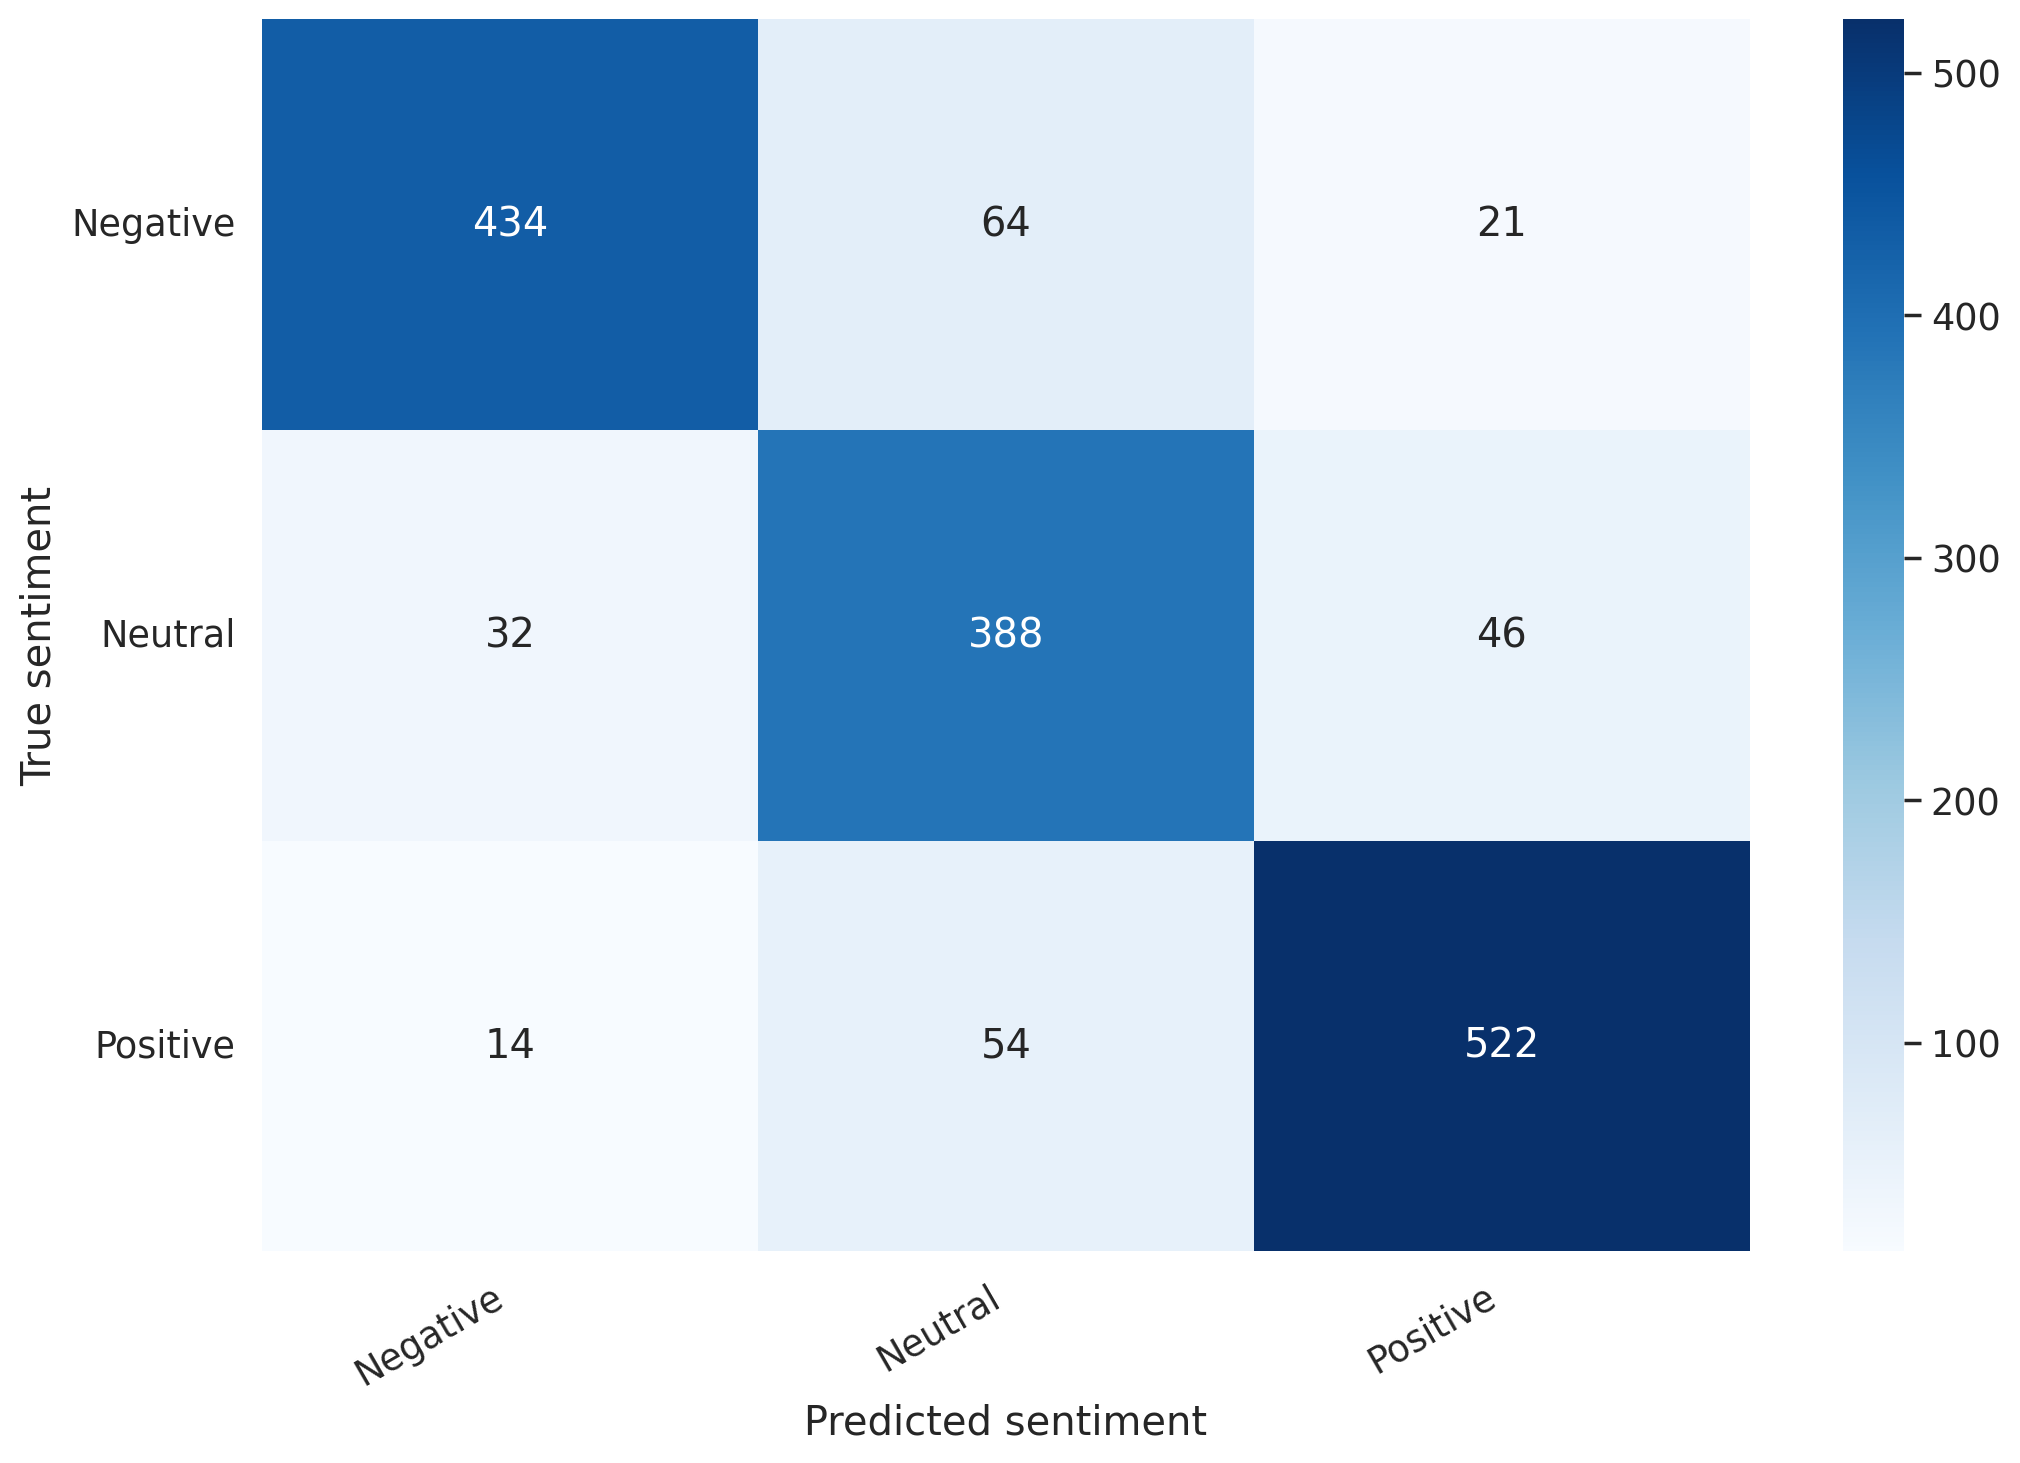

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Cheking how the model is Performing. 

In [ ]:
#Choosing a review at a random index 
idx = 100
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

##### Showing the Review

In [ ]:
print("\n".join(wrap(review_text)))

I was enjoying this app and decided to buy the premium features. But
they took the money and provided nothing at all. I tries contacting
the developer via Email and no answer at all. Stay Away.


In [ ]:
print(f'True sentiment: {class_names[true_sentiment]}')

True sentiment: Negative


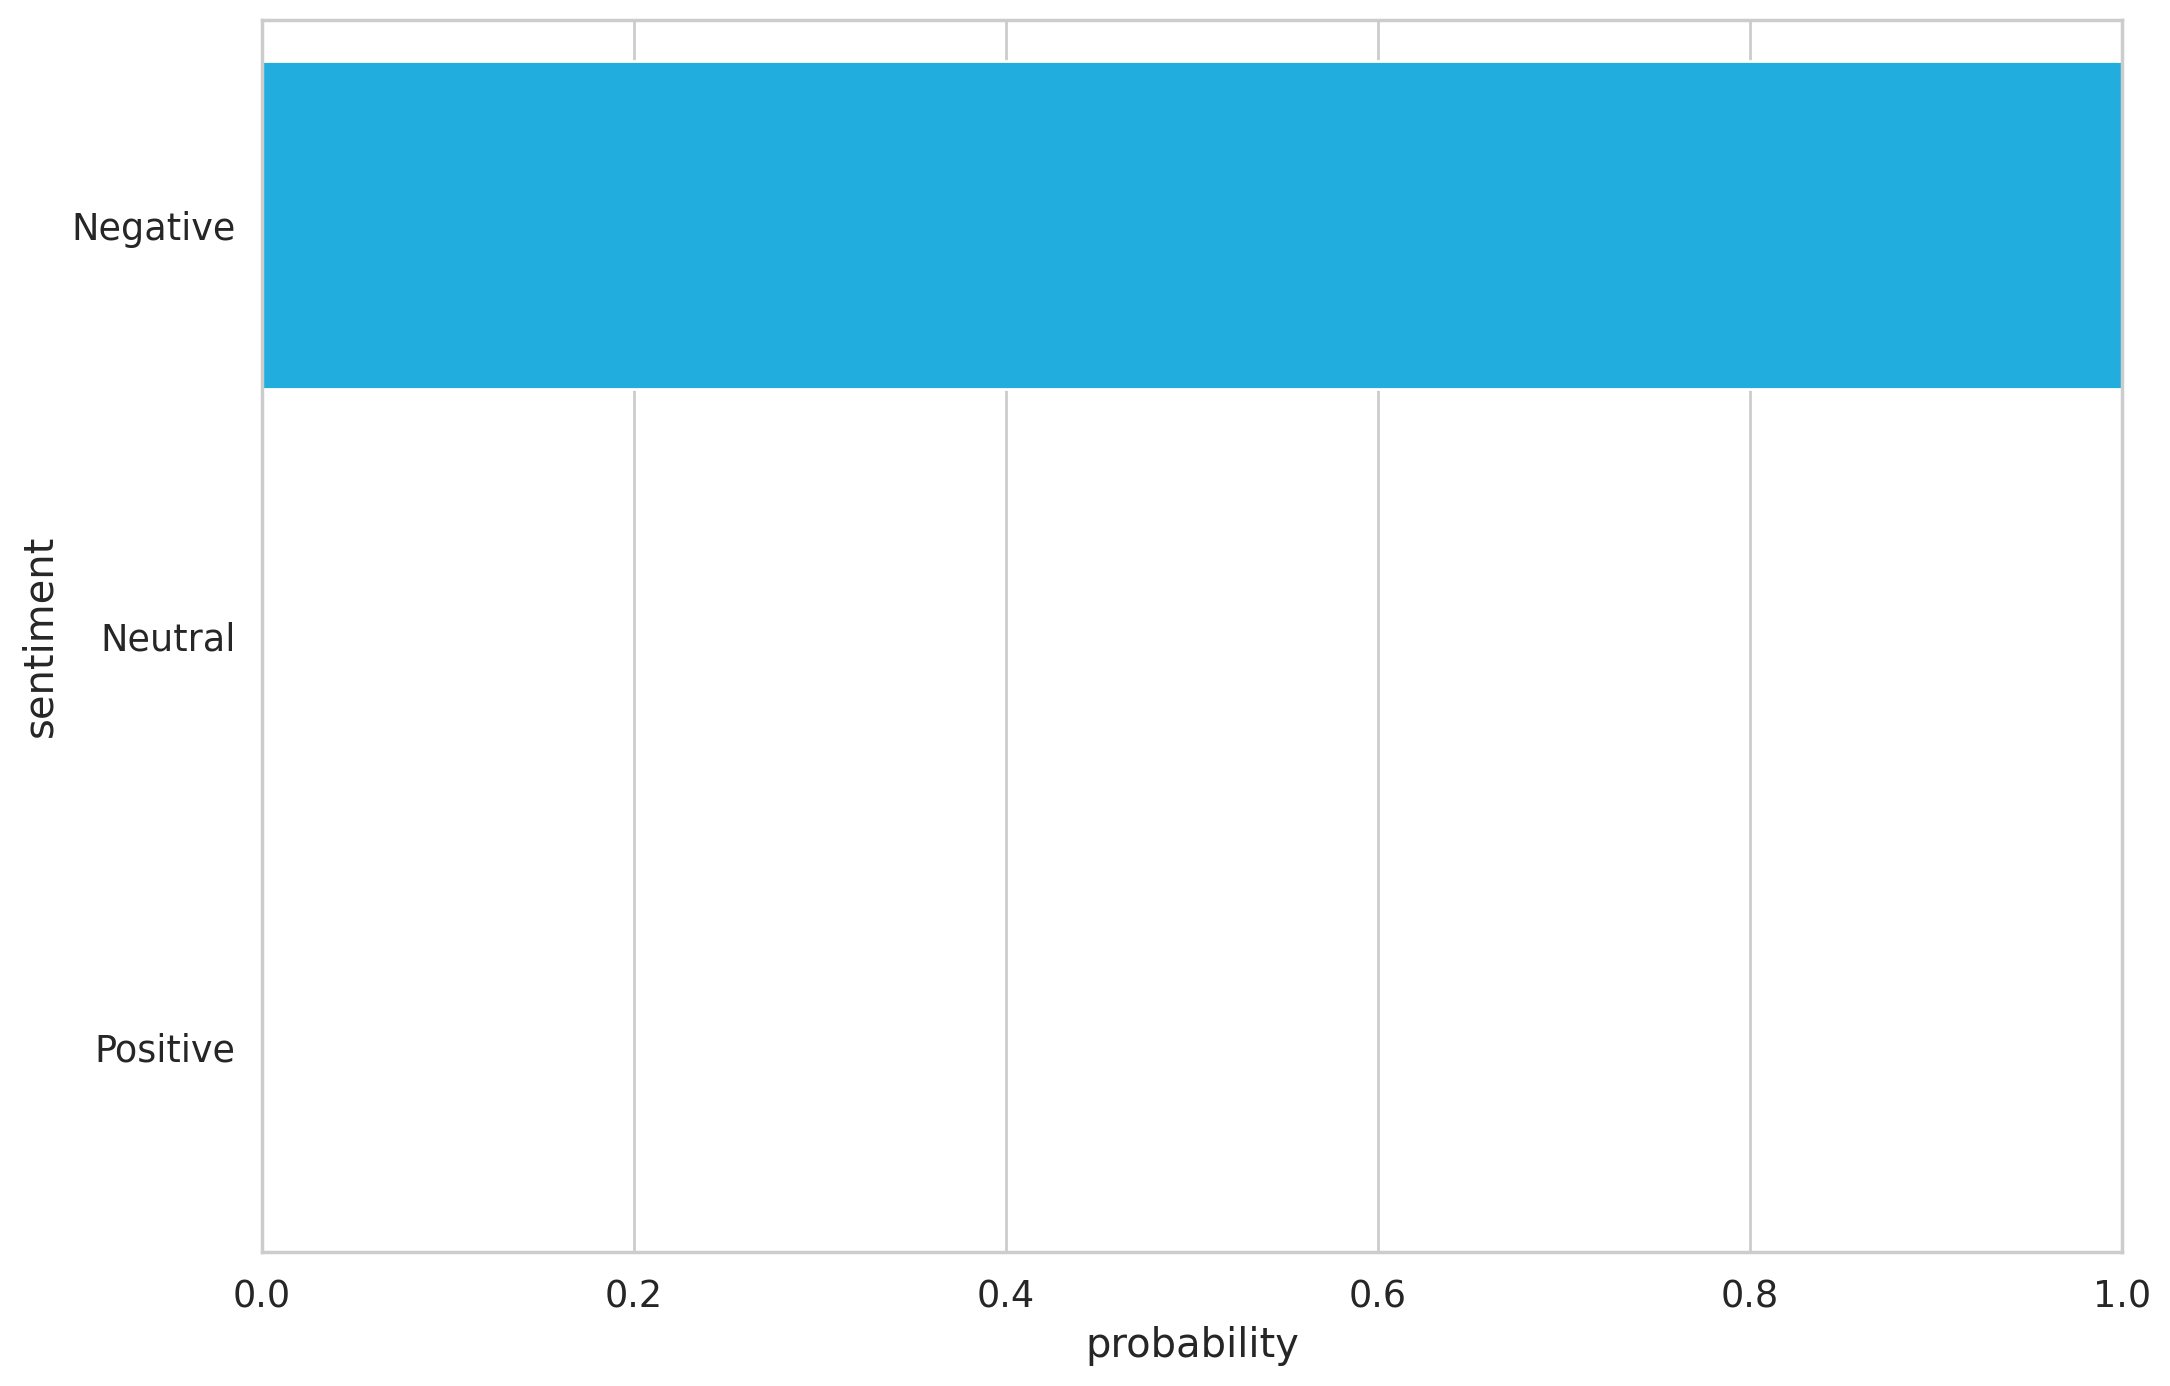

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

#### Predicting on raw text 

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I was enjoying this app and decided to buy the premium features. But they took the money and provided nothing at all. I tries contacting the developer via Email and no answer at all. Stay Away.
Sentiment  : Positive


## Conclusion 

Based on the evaluation, the model performs well on the Reviews dataset and random raw text, making it suitable for production. However, considering the case-sensitivity of the bert-cased model used, using a bert-uncased variant may be worth exploring for better performance. To improve training, increasing epochs and reducing the learning rate could be beneficial. Therefore, it is recommended to consider the bert-uncased variant and fine-tune training hyperparameters for future deployments.